# Homework 1: COVID-19 Caese Prediction (Regression)

Author: Cao Yanfei

Objectives:
* Solve a regression problem with deep neural networks (DNN).
* Understand basic DNN training tips.
* Get familiar with pytorch.

# 1 Preparation

## 1.1 Download Data

If the Google drive links are dead, download data from [Kaggle](https://www.kaggle.com/c/ml2021spring-hw1/data), and upload data manually to the workspace.

In [1]:
# !gdown --id '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' --output covid.train.csv
# !gdown --id '1CE240jLm2npU-tdz81-oVKEF3T2yfT1O' --output covid.test.csv

trainPath = '.\\dataset\\covid_train.csv'          # path to training data
testPath = '.\\dataset\\covid_test.csv'            # path to testing data

## 1.2 Import Some Packages

In [2]:
# pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# data process
import numpy as np
import csv
import os

# plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

D:\software\Anaconda3\installation\envs\test\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1.3 Some Utilities

In [3]:
def getDevice():
    '''
    Get device (if GPU is available, use GPU).
    '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plotLrCurve(lrRecord):
    '''
    Plot learning rate variation during each epoch.
    '''
    figure(figsize=(6, 6))
    plt.plot(range(len(lrRecord)), lrRecord, c='tab:purple')
    plt.xlim(0, 1000)
    plt.ylim(0, 0.001)
    plt.xticks(np.arange(0, 1200, 200))
    plt.yticks(np.arange(0, 0.0012, 0.0002))
    plt.xlabel('Training step/epoch')
    plt.ylabel('Learning rate')
    plt.show()

def plotLossCurve(lossRecord, title=''):
    '''
    Plot DNN learning curve (training and validation loss).
    '''
    totalSteps = len(lossRecord['train'])
    # each batch size
    x1 = range(totalSteps)
    # each epoch
    x2 = x1[:: len(lossRecord['train']) // len(lossRecord['validate'])]

    figure(figsize=(10, 8))
    # T10调色盘适用于离散分类，颜色名称以'tab:'为前缀
    plt.plot(x1, lossRecord['train'], c='tab:red', label='training')
    plt.plot(x2, lossRecord['validate'], c='tab:cyan', label='validation')
    plt.xlim(-500, 9000)
    plt.ylim(0., 5.)
    plt.xticks(np.arange(0, 10000, 1000))
    plt.yticks(np.arange(0., 6., 0.5))
    plt.xlabel('Training step/batch')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

def plotPredCurveOnVali(validateSet, model, device, lim=40, preds=None, targets=None):
    '''
    Plot DNN prediction.
    '''
    if preds is None or targets is None:
        model.eval()
        
        preds, targets = [], []
        for featureData, target in validateSet:
            featureData, target = featureData.to(device), target.to(device)
            with torch.no_grad():
                pred = model(featureData)
                preds.append(pred.detach().cpu())
                targets.append(target.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(8, 8))
    plt.scatter(targets, preds, c='tab:red', alpha=0.5)
    plt.plot([0, lim], [0, lim], c='tab:cyan')
    plt.xlim(0, 40)
    plt.ylim(0, 40)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground truth v.s. prediction')
    plt.show()

## 1.4 Set Random Seeds

In [4]:
# set a random seed for reproducibility
myseed = 42069
np.random.seed(myseed)
# 在NN训练中，参数是默认随机初始化的，设置种子每次训练的初始化都是固定的，可复现
# 为CPU设置随机种子，用于生成随机数，可复现
torch.manual_seed(myseed)

# get current available device ('cpu' or 'cuda')
device = getDevice()
if device == 'cuda':
    # 为所有GPU设置随机种子，用于生成随机数，可复现
    torch.cuda.manual_seed_all(myseed)
    
    # cuDNN是nvidia专为DNN开发的GPU加速库，针对卷积、池化等操作做了非常多底层优化，比一般GPU快得多，大多主流深度学习框架都支持，包括pytorch
    # 设置torch.backends.cudnn.deterministic=True
    # 每次返回的卷积算法将是确定的，即默认算法，配合torch固定随机种子，可保证每次运行网络在相同输入下有相同输出，可复现
    torch.backends.cudnn.deterministic = True

    # 设置torch.backends.cudnn.benchmark=True
    # 一般设置在程序开头
    # 会在程序开始时额外花费一定预处理时间，内置auto-tuner为整个网络的每个卷积层搜索适合的卷积实现算法，优化训练效率
    # 适用场景：网络结构固定，若卷积层一直变化，会导致程序不停做优化，耗费更多时间
    #           网络输入形状（batchsize、image size、channel）固定，若输入形状变化，会重新搜寻最优算法
    #           大部分情况，是适用的
    # 使用GPU时，默认会使用cuDNN加速，但是默认torch.backends.cudnn.benchmark=False
    torch.backends.cudnn.benchmark = False

# 2. Preprocess

Three kinds of datasets:
* `train`: for training
* `validate`: for validation
* `test`: for testing (w/o target value)

## 2.1 Dataset

The`COVID19Dataset` below does:
* read `.csv` files
* extract features
* split `covid_train.csv` into train/validate sets
* normalize features

In [5]:
class COVID19Dataset(Dataset):
    '''
    Dataset for loading and preprocessing the COVID19 dataset.
    member:
        self.mode
        self.data
        self.target
        self.dim
        
    '''
    def __init__(self, path, mode='train', targetOnly=False):
        '''
        mode: value should be 'train', 'validate' or 'test'
        targetOnly: True: only select 2 tested_positive columns and 40 states as features.
        '''
        if mode not in ['train', 'validate', 'test']:
            raise Exception('Parameter mode is not valid!')
        self.mode = mode
        
        # Read data into numpy arrays
        # with open(path, 'r') as fp:
        #    # 按行读取，二维list，每行一个list
        #    data = list(csv.reader(fp))
        #    data = np.array(data[1:])[:, 1:].astype(float)
        data = np.loadtxt(path, dtype=str, delimiter=',')
        data = data[1:, 1:].astype(float)
        
        # Select feature indices,not inlcude target column
        if not targetOnly:
            featureColIndices = list(range(93))
        else:
            # Using 40 states & 2 tested_positive features (indices = 57 & 75)
            featureColIndices = list(range(40)) + [57, 75]
        
        if self.mode == 'test':
            # Testing data
            # data: 893 x 93 (40 states + day1(18) + day2(18) + day3(17))
            data = data[:, featureColIndices]
            
            # Convert data from ndarray into tensor
            self.data = torch.FloatTensor(data)
        
        if self.mode in ['train', 'validate']:
            # Training data (train/validate sets)
            # data: 2700 x 94 (40 states + day1(18) + day2(18) + day3(18))
            # the last column: target
            target = data[:, -1]
            data = data[:, featureColIndices]
            
            # Split training data into train & validate sets
            if mode == 'train':
                rowIndices = [i for i in range(len(data)) if i % 10 != 0]
            if mode == 'validate':
                rowIndices = [i for i in range(len(data)) if i % 10 == 0]
        
            # Convert data from ndarray into tensor
            self.data = torch.FloatTensor(data[rowIndices])
            self.target = torch.FloatTensor(target[rowIndices])
        
        # Normalize features
        # Z-score standardization 0均值标准化
        # 把有量纲表达式变为无量纲表达式 （x- mean）/std，处理后数据符合标准正态分布，均值为0，标准差为1
        # 归一化的优点：1）加快梯度下降求最优解的速度；2）可能提高精度，让不同维度间的特征在数值上有一定比较性
        self.data[:, 40:] = (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True))\
                            / self.data[:, 40:].std(dim=0, keepdim=True)
        
        # feature dim
        self.dim = self.data.shape[1]
        
        print('Finished reading the {} set of COVID19 Dataset({} samples are found, dim of each sample is {})'\
              .format(self.mode, len(self.data), self.dim))
    
    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'validate']:
            # For training and validation
            return self.data[index], self.target[index]
        # For testing
        return self.data[index]
    
    def __len__(self):
        # Return the size of the dataset
        return len(self.data)

## 2.2 DataLoader
A `DataLoader` loads data from a given `Dataset` into batches.

In [6]:
def prepDataloader(path, mode, batchSize, nJobs=0, targetOnly=False):
    '''
    Generate a dataset, then is put into a DataLoader.
    '''
    # Construct a dataset
    dataset = COVID19Dataset(path, mode=mode, targetOnly=targetOnly)
    
    # Construct a dataloader
    # shuffle is only needed in training mode
    # pin_memory 锁页内存：默认为False，与电脑硬件性能有关，当系统卡住或交换内存过多时，设置False
    # pin_memory=True锁页内存存放的内容任何情况都不会与主机虚拟内存（硬盘）进行交换，这样内存的Tensor转义到GPU的显存会更快
    dataloader = DataLoader(dataset, batchSize, shuffle=(mode == 'train'), drop_last=False, num_workers=nJobs, pin_memory=False)
    return dataloader

## 2.3 Deep Neural Network

`NeuralNet` is designed for regression based on `nn.Module` . The DNN consists of 2 fully-connected layers with ReLU activation. This module also included a function `calcuLoss` for calculating loss.

In [7]:
class NeuralNet(nn.Module):
    '''
    A simple fully-connected deep neural network.
    member:
        self.net
        self.criterion
    '''
    def __init__(self, inputDim):
        super(NeuralNet, self).__init__()
        
        # Define your neural network
        self.net = nn.Sequential(
            nn.Conv1d(1, 32, 5, 1, 2),
            nn.MaxPool1d(4),
            nn.Conv1d(32, 64, 5, 1, 2),
            nn.MaxPool1d(4),
            nn.Flatten(),
            nn.Linear(64 * (inputDim // 4 // 4), 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        ) 
        
        # Construct Mean squared error loss, and move to device
        # reduction: default value is 'mean'
        self.criterion = nn.MSELoss(reduction='mean').to(device)
    
    def forward(self, input):
        '''
        given  (batchSize * inputDim)input of size
        '''
        return self.net(input.unsqueeze(1)).squeeze(1)
    
    def calcuLoss(self, pred, target):
        '''
        Calculate loss.
        '''
        return self.criterion(pred, target)

# 3 Train/Validate/Test Func

## 3.1 Training Func

In [8]:
def train(trainSet, validateSet, model, config, device):
    '''
    DNN training
    '''
    # Maximum number of epochs
    nEpochs = config['nEpochs']
    
    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(model.parameters(), **config['optimHyparas'])
    # Cosine annealing learning rate
    # optimizer: 提供初始学习率
    # T_max: 整个训练过程中cosine循环的次数
    # eta_min: 最小学习率，默认为0
    # last_epoch: 上一次epoch的索引，便于计算当前的学习率，默认为-1
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=nEpochs / 10, eta_min=0, last_epoch=-1)
    
    # minMse (minum MSE loss on validation set) is used to judge early stop count and whether to save the model
    minMse = 1000.
    # for recording training loss
    lossRecord = {'train': [], 'validate': []}
    lrRecord = []
    earlyStopCnt = 0
    epoch = 0
    while epoch < nEpochs:
        # Set model to training mode
        # 启用Batch Normalization（BN）和Dropout层
        # 模型中有BN和Dropout层，需要在train阶段添加model.train()
        # 保证BN层能够用到每一批数据的均值和方差；对于Dropout，随机取一部分网络来训练更新参数
        model.train()
        
        # iterate through the dataloader
        for featureData, target in trainSet:
            # move data to device (cpu/cuda)
            featureData, target  = featureData.to(device), target.to(device)
            # forward pass (compute output)
            pred = model(featureData)
            # compute loss
            mseLoss = model.calcuLoss(pred, target)
            
            # set gradient to zero
            optimizer.zero_grad()
            # compute gradient (backpropagration)
            mseLoss.backward()
            # update model with optimizer
            optimizer.step()
            # convert tensor training loss (one batch) into ragular value, then save it into a list
            lossRecord['train'].append(mseLoss.detach().cpu().item())
            
        # After each epoch, test your model on the validation (development) set.
        # calculate total mean MSELoss in the whole validate set
        validateMseLoss = validate(validateSet, model, device)
        if validateMseLoss < minMse:
            # Save model if your model improved
            minMse = validateMseLoss
            print('Saving model (epoch = {:4d}, loss = {:.4f})'.format(epoch + 1, minMse))
            
            # Save model to specified path
            torch.save(model.state_dict(), config['savePath'])
            
            earlyStopCnt = 0
        else:
            earlyStopCnt += 1
        # save validation loss (one epoch) into a list
        lossRecord['validate'].append(validateMseLoss)
        
        # get and then tune learning rate
        lrRecord.append(optimizer.state_dict()['param_groups'][0]['lr'])
        scheduler.step()

        epoch += 1
        # Stop training if your model stops imrpoving on validation set for config['earlyStop'] epochs.
        if earlyStopCnt > config['earlyStop']:
            break

    print('Finished training after {} epochs'.format(epoch))
    return minMse, lossRecord, lrRecord

## 3.2 Validation Func

In [9]:
def validate(validateSet, model, device):
    # set model to evaluation mode
    # 不启用Batch Normalization（BN）和Dropout层
    # 模型中有BN和Dropout层，需要在validate和test阶段添加model.eval()
    # 保证BN层能够用全部训练数据的均值和方差，即test过程要保证BN层的均值和方差不变；对于Dropout，利用率所有网络连接，不随机舍弃神经元
    # 若不加model.eval()，有输入数据，即使不训练，也会改weight（模型中含有BN和Dropout带来的性质）
    model.eval()
    
    totalLoss = 0
    # iterate through dataloader
    for featureData, target in validateSet:
        # move data to device (cpu/cuda)
        featureData, target  = featureData.to(device), target.to(device)
        
        # disable gradient calculation
        with torch.no_grad():
            # forward pass (compute output)
            pred = model(featureData)
            # compute loss
            mseLoss = model.calcuLoss(pred, target)
        # accumulate loss
        totalLoss += mseLoss.detach().cpu().item() * len(featureData)
    # compute averaged loss
    totalLoss /= len(validateSet.dataset)
    
    return totalLoss

## 3.3 Testing Func

In [10]:
def test(testSet, model, device):
    # set model to evaluation mode
    model.eval()
    preds = []
    
    # iterate through dataloader
    for featureData in testSet:
        # move data to device (cpu/cuda)
        featureData = featureData.to(device)
        
        # diable gradient calculation
        with torch.no_grad():
            # forward pass (compute output)
            pred = model(featureData)
            # collect prediction
            preds.append(pred.detach().cpu())
    # concatenate all predictions and convert to a numpy array
    preds = torch.cat(preds, dim=0).numpy()
    return preds

## 4 Setup Hyper-parameters

`config` contains hyper-parameters for training and the path to save the model.

In [11]:
# The training model wil be saved to ./models/
# exist_ok=True: if this directory exists, not cause FileExistsError.
os.makedirs('models', exist_ok=True)
# Using 40 states & 2 tested_positive features
targetOnly = False

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'nEpochs': 3000,                        # maximum number of epochs
    'batchSize': 270,                       # mini-batch size for dataloader
    'optimizer': 'SGD',                     # optimization algorithm (optimizer in torch.optim), SGD: Stochastic Gradient Descent
    'optimHyparas': {                       # hyper-parameters for the optimizer (depends on which optimizer is used)
        'lr': 0.001,                        # learning rate of SGD
        'momentum': 0.9,                    # momentum for SGD
        'weight_decay': 0.1                 # L2 regularization/weight decay: repress model expressiveness to prevent overfitting
                                            # NOTE: Adam+L2 -> lose effectiveness
    },
    'earlyStop': 200,                       # early stopping epochs (the number epochs since your model's last improvement)
    'savePath': 'models/best_model.pth'     # model will be saved here
}

# 5 Load Data and Model

In [12]:
trainSet = prepDataloader(trainPath, 'train', config['batchSize'], nJobs=0, targetOnly=targetOnly)
validateSet = prepDataloader(trainPath, 'validate', config['batchSize'], nJobs=0, targetOnly=targetOnly)
testSet = prepDataloader(testPath, 'test', config['batchSize'], nJobs=0, targetOnly=targetOnly)

Finished reading the train set of COVID19 Dataset(2430 samples are found, dim of each sample is 93)
Finished reading the validate set of COVID19 Dataset(270 samples are found, dim of each sample is 93)
Finished reading the test set of COVID19 Dataset(893 samples are found, dim of each sample is 93)


In [13]:
# Construct model and move to device
model = NeuralNet(trainSet.dataset.dim).to(device)

# 6 Start Training

In [14]:
modelLoss, modelLossRecord, lrRecord = train(trainSet, validateSet, model, config, device)

Saving model (epoch =    1, loss = 106.0265)
Saving model (epoch =    3, loss = 35.5123)
Saving model (epoch =    5, loss = 30.6995)
Saving model (epoch =    6, loss = 12.1281)
Saving model (epoch =    7, loss = 11.3989)
Saving model (epoch =    8, loss = 7.5735)
Saving model (epoch =    9, loss = 6.3756)
Saving model (epoch =   10, loss = 5.2022)
Saving model (epoch =   11, loss = 4.3729)
Saving model (epoch =   12, loss = 4.2425)
Saving model (epoch =   13, loss = 3.8936)
Saving model (epoch =   14, loss = 2.9395)
Saving model (epoch =   16, loss = 2.4808)
Saving model (epoch =   17, loss = 2.3387)
Saving model (epoch =   19, loss = 2.1719)
Saving model (epoch =   20, loss = 2.0012)
Saving model (epoch =   22, loss = 1.8813)
Saving model (epoch =   23, loss = 1.8293)
Saving model (epoch =   25, loss = 1.7647)
Saving model (epoch =   26, loss = 1.6892)
Saving model (epoch =   28, loss = 1.5826)
Saving model (epoch =   29, loss = 1.5316)
Saving model (epoch =   35, loss = 1.4033)
Savin

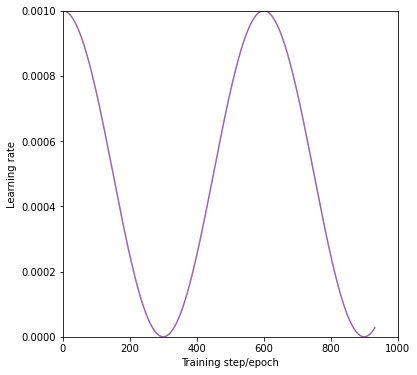

In [15]:
# Show lr variation on each epoch
plotLrCurve(lrRecord)

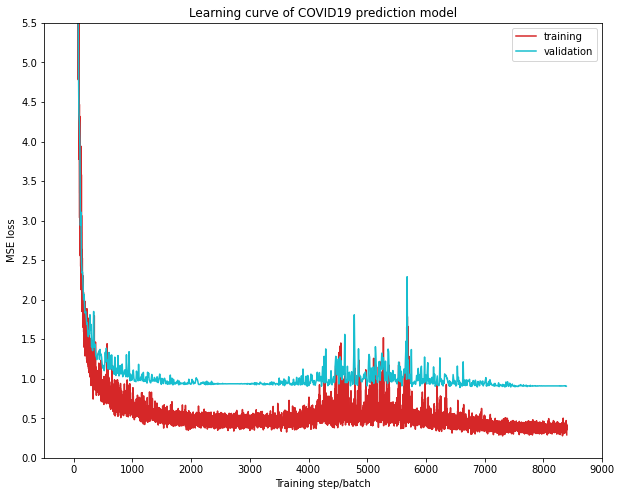

In [16]:
# Show loss variation on training set and validation set during training
plotLossCurve(modelLossRecord, title='COVID19 prediction model')

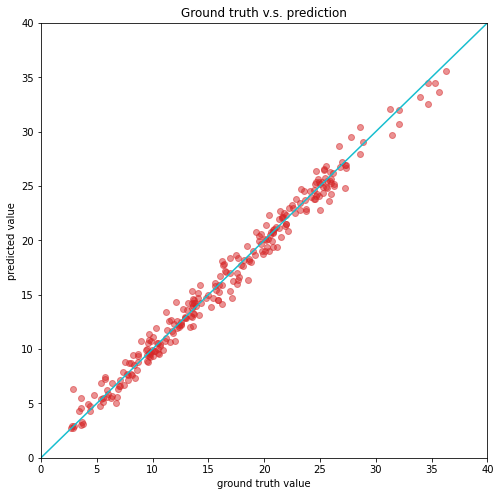

In [17]:
# load the best model
del model
model = NeuralNet(trainSet.dataset.dim).to(device)
bestModel = torch.load(config['savePath'], map_location='cpu')
model.load_state_dict(bestModel)

# Show prediction on validation set based on the best training model.
plotPredCurveOnVali(validateSet, model, device)

# 7 Testing

The model predictions on testing set will be stored at `preds.csv`.

In [18]:
def savePreds(preds, fileName):
    '''
    Save predictions to speified file
    '''
    # with open(fileName, 'w') as fp:
    #     writer = csv.writer(fp)
    #     writer.writerow(['id', 'tested_positive'])
    #     # enumerate()用于将一个可遍历的数据对象组合成一个索引序列（元素为(数据下标，数据)），一般用于for循环中
    #     for index, prediction in enumerate(preds):
    #         writer.writerow([index, prediction])
    title = np.array([['id', 'tested_positive']])
    writeData = np.concatenate((title, np.array(list(enumerate(preds)))))
    np.savetxt(fileName, writeData, fmt='%s', delimiter=',')
    
    print('Succeeded in saving results to {}.'.format(fileName))

# Predict COVID19 cases with the best model
preds = test(testSet, model, device)
# Save predictions to preds.csv
savePreds(preds, 'preds.csv')

Succeeded in saving results to preds.csv.


# 8 Hints

## Simple Baseline

* Run these codes

## Medium Baseline
* Feature selection: 40 states + 2 `tested_positive`

## Strong Baseline

* Feature selection (what other features are useful?)
* DNN architecture (layers? dimension? activation function?)
* Training (mini-batch? optimizer? learning rate?)
* L2 regularization

# Reference

Original source: Heng-Jui Chang (https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb)